In [2]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

> #### <b>Compare modelled Topt and observation</b>

In [3]:
Topt_obs_filename   = '/Users/hzc/data/LP/Topt_0709_FLUX_check.csv'
Topt_model_filename = '/Users/hzc/data/MoreAnalysis_2024/Model_FilterOut_202409/output_202412/01Oct24_Canopy_defaultLAI.csv'

In [4]:
# read in
Topt_obs   = pd.read_csv(Topt_obs_filename, index_col = 0)
Topt_model = pd.read_csv(Topt_model_filename, index_col = 0)

# calculate average of each site
Topt_obs_mean   = Topt_obs.mean(axis=1)
Topt_obs_sd     = Topt_obs.std(axis=1)
Topt_model_mean = Topt_model.mean(axis=1)
Topt_model_sd   = Topt_model.std(axis=1)

Topt_obs['Topt_obs_mean'] = Topt_obs_mean
Topt_model['Topt_model_mean'] = Topt_model_mean
Topt_obs['Topt_obs_sd'] = Topt_obs_sd
Topt_model['Topt_model_sd'] = Topt_model_sd

# merge
dfs = [Topt_obs['Topt_obs_mean'],
        Topt_model['Topt_model_mean'],
        Topt_obs['Topt_obs_sd'],
        Topt_model['Topt_model_sd']
        ]
df = reduce(lambda x, y: pd.merge(x, y, on="site", how="inner"), dfs)
df = df.dropna(axis='index',how="any") 

In [27]:
# OLS regression: default model
X = sm.add_constant(df['Topt_model_mean'])
model = sm.OLS(df['Topt_obs_mean'], X)
results = model.fit()
R2 = round(results.rsquared,2)
coef_df = pd.DataFrame({"params": results.params,   # coefficients
                        "t": round(results.tvalues,3),       # t-value
                        "p-values": round(results.pvalues,4) # p-value
                         })
coef_df[['coef_0.025','coef_0.975']] = results.conf_int() # confidence interval
rmse = ((df['Topt_obs_mean']-results.fittedvalues)**2).mean()**0.5
print(coef_df)
print("R2 and RMSE", R2, rmse)

                   params       t  p-values  coef_0.025  coef_0.975
const           -2.747253  -1.241    0.2182   -7.151695     1.65719
Topt_model_mean  1.181413  12.543    0.0000    0.994076     1.36875
R2 and RMSE 0.65 2.720470114510559


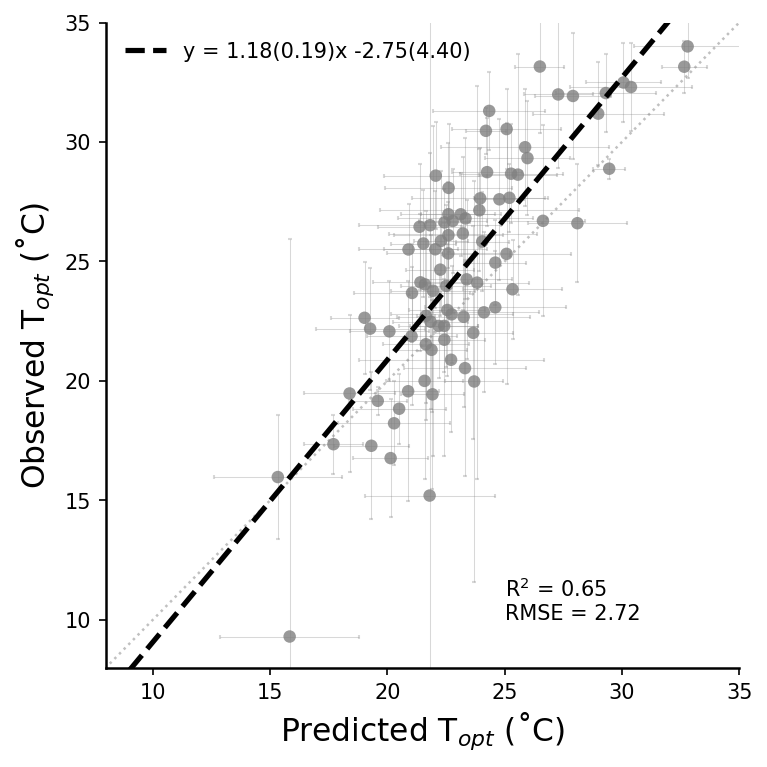

In [40]:
# reg. line
predictX = np.arange(6,35,2)
predictY = results.predict(sm.add_constant(predictX))

# set label
str1 = 'y = %.2f(%.2f)x '%(coef_df.loc['Topt_model_mean','params'],
                                  coef_df.loc['Topt_model_mean','params'] - coef_df.loc['Topt_model_mean','coef_0.025']) + \
        '%.2f(%.2f)'%(coef_df.loc['const','params'],
                                  coef_df.loc['const','params'] - coef_df.loc['const','coef_0.025'])
str2 = 'R$^2$ = %.2f\n'%R2 + \
       'RMSE = %.2f'%rmse
# str1 = 'With thermal adjustments\n'+\
#         '(slope = %.2f$\pm$%.2f, '%(coef_df.loc['Topt_model_mean','params'],
#                                   coef_df.loc['Topt_model_mean','params'] - coef_df.loc['Topt_model_mean','coef_0.025']) + \
#        '$R^{2}$=%.2f)'%R2

# plot
fig, ax = plt.subplots(figsize=(5, 5),
                       dpi=150,
                       layout='constrained')
ax.scatter(df['Topt_model_mean'], df['Topt_obs_mean'],
           zorder=3,
           color='grey',
           edgecolors='none',
           alpha=.8)
ax.errorbar(df['Topt_model_mean'], df['Topt_obs_mean'],
            xerr=df["Topt_model_sd"],yerr=df['Topt_obs_sd'],
                fmt='none',
                capsize=1,
                lw=.5,
                color='grey',
                alpha=.3,
                zorder=1)
ax.plot(predictX, predictY,
        color='k', lw=2.5,
        linestyle='--',
        zorder=5,
        label=str1
        )
ax.plot([5,36],[5,36],
        linestyle=':',
        color='silver',
        lw=1.2,
        zorder=0) 
ax.text(25, 10, str2)
ax.legend(loc='best',
          frameon=False,
          fontsize=10)
ax.set_xlim(8,35)
ax.set_ylim(8,35)
# ax.set_xticks(np.arange(15,36,5))
ax.set_xlabel("Predicted T$_{opt}$ (˚C)", fontsize=15)
ax.set_ylabel("Observed T$_{opt}$ (˚C)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)